<a href="https://colab.research.google.com/github/3x10e8/telluride-21/blob/neurodyn/Morris_Lecar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Morris-Lecar Model (1981)

The model is originally described in:

Morris, C., & Lecar, H. (1981). Voltage oscillations in the barnacle giant muscle fiber. Biophysical Journal, 35(1), 193–213. https://doi.org/10.1016/S0006-3495(81)84782-0

μ

In [1]:
from numpy import tanh, cosh
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.integrate import odeint

In [2]:
# Constants for all experiments

## equilibrium potentials
VL_mV = -50
VCa_mV = 100
VK_mV = -70

C_μF  = 20 # 1.0 # membrane capacitance, in uF/cm^2

# init conditions
V0_mV = -50 # V(0)

In [32]:
def Xinf(V, Va, Vb):
  return 0.5*(1 + tanh((V-Va)/Vb))

def λinf(λ, V, Va, Vb):
  return λ*cosh((V-Va)/(2*Vb))

def f_ML(y, t, params):
  '''
  I_μA # applied
  IL_μA # leak
  ICa_μA # calcium current
  IK_μA # potassium current
  '''

  V_mV, M, N = y
  gL_mS, gCa_mS, gK_mS, V1_mV, V2_mV, V3_mV, V4_mV, λMinf_Hz, λNinf_Hz, sig_gen = params

  dVdt = 0
  dMdt = 0 # in case its unused

  I_μA = sig_gen(t)
  dVdt += I_μA

  IL_μA = gL_mS * (V_mV - VL_mV)
  dVdt -= IL_μA

  if gCa_mS != 0:
    ICa_μA = gCa_mS * M * (V_mV - VCa_mV)
    dVdt -= ICa_μA

  IK_μA = gK_mS * N * (V_mV - VK_mV)
  dVdt -= IK_μA
  
  dVdt /= C_μF

  if gCa_mS != 0:
    Minf = Xinf(V_mV, V1_mV, V2_mV)
    λM = λinf(λMinf_Hz, V_mV, V1_mV, V2_mV) 
    dMdt = λM*(Minf-M)

  Ninf = Xinf(V_mV, V3_mV, V4_mV)
  λN = λinf(λNinf_Hz, V_mV, V3_mV, V4_mV)
  dNdt = λN*(Ninf-N)
  derivs = [dVdt, dMdt, dNdt]

  return derivs

def run_and_plot(f_ML, y0, tt, params, sig_gens, fig):
  axV, axM, axN = ax # grab axis handles
  params.extend([0]) # placeholder for sig_gen

  for sig_gen in sig_gens:
    # setup input
    params[-1] = sig_gen # update sig_gen for current iteration

    # call the ODE solver
    START_TIME = time.time()  # for timing execution
    psoln = odeint(
        f_ML,
        y0,
        tt,
        args=(params,),
        # mxstep=5000000,
        # rtol=1e-15,
        # atol=1e-15,
        # full_output=1,
    )

    print("Done in {:.2f}s".format(time.time() - START_TIME))

    # add traces
    axV.plot(tt, psoln[:, 0], label='$I = {}μA$'.format(sig_gen(0)))
    axM.plot(psoln[:, 1], psoln[:, 0], label='$I = {}μA$'.format(sig_gen(0)))
    axN.plot(psoln[:, 2], psoln[:, 0], label='$I = {}μA$'.format(sig_gen(0)))

  # plot formatting
  for ax_ in [axV, axM, axN]:
    ax_.set_ylabel('Voltage [mV]')
    ax_.legend(loc = 'upper right')
    ax_.grid()
    
  axV.set_xlabel('Time [ms]')
  axM.set_xlabel('M')
  axM.set_xlim(-.01, 1)
  axN.set_xlabel('N')
  axN.set_xlim(-.01, 1)
  plt.tight_layout()

## $K^+$ conductance ($Ca^{2+}$ free solution)
Parameter values from Fig. 2:

In [33]:
# Max / instantaneous conductances
gL_mS = 3
gK_mS = 8

# Max rate constants for Ca and K channel opening
λMinf_Hz = 1
λNinf_Hz = 1/15

# Params for gating dynamics
V1_mV = 0 # unused
V2_mV = 0 # unused
V3_mV = -1
V4_mV = 14.5

# Unused conducatance
gCa_mS = 0 # Ca free external saline
gsCa_mS = 0 # g*_Ca: conductance constant for nonlinear ICa

# Collect model parameters
params = []
params.extend([gL_mS, gCa_mS, gK_mS])
params.extend([V1_mV, V2_mV, V3_mV, V4_mV])
params.extend([λMinf_Hz, λNinf_Hz])

Done in 0.16s
Done in 0.18s
Done in 0.20s


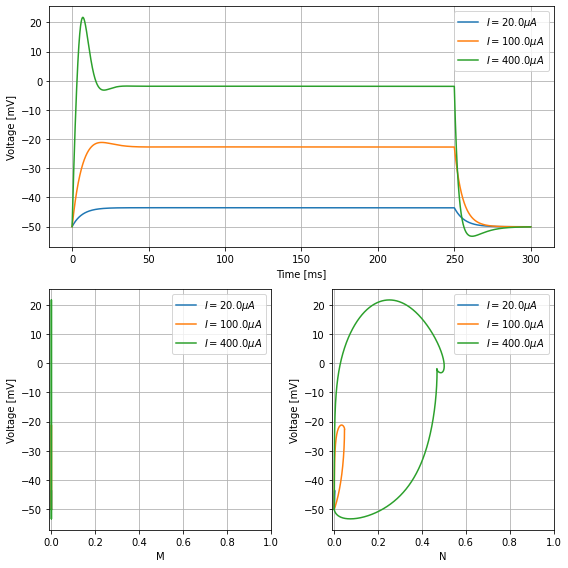

In [34]:
# Initial conditions
M0 = 0 # unused
N0 = Xinf(V0_mV, V3_mV, V4_mV)
y0 = [V0_mV, M0, N0]

# Time course of solution
tend_ms = 300.
dt = .1e-3
tt = np.arange(0.0, tend_ms, dt)

# Input stimuli to test and plot as separate traces
stim_end_ms = 250
sig_gens = []
sig_gens.append(lambda t: 20*float(t <= stim_end_ms))
sig_gens.append(lambda t: 100*float(t <= stim_end_ms))
sig_gens.append(lambda t: 400*float(t <= stim_end_ms))

# Generate figure axes for plotting
fig = plt.figure(figsize=(8,8))
axV = plt.subplot(211)
axM = plt.subplot(223)
axN = plt.subplot(224)
ax = [axV, axM, axN]

# Simulate and plot results
run_and_plot(f_ML, y0, tt, params, sig_gens, ax)

Parameters from Fig. 6:

In [24]:
# Max / instantaneous conductances
gCa_mS = 4
gL_mS = 3
gK_mS = 8

# Max rate constants for Ca and K channel opening
λMinf_Hz = 1
λNinf_Hz = .1

# Params for gating dynamics
V1_mV = 0
V2_mV = 15
V3_mV = 10
V4_mV = 10

# Unused conducatance
gsCa_mS = 0 # g*_Ca: conductance constant for nonlinear ICa

# Collect model parameters
params = []
params.extend([gL_mS, gCa_mS, gK_mS])
params.extend([V1_mV, V2_mV, V3_mV, V4_mV])
params.extend([λMinf_Hz, λNinf_Hz])

Done in 0.23s


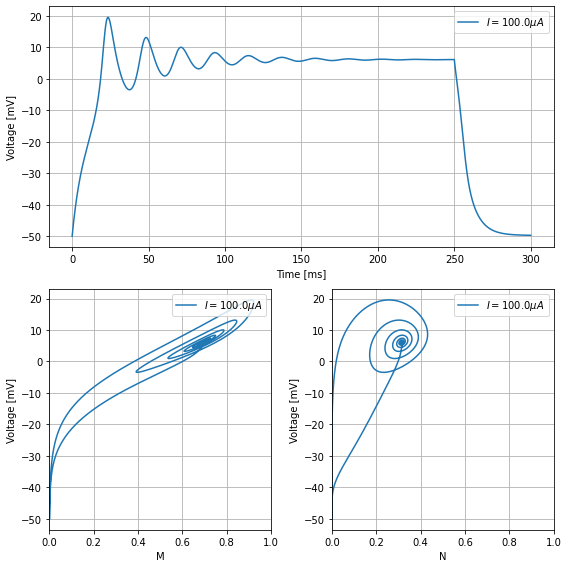

In [25]:
# Initial conditions
M0 = Xinf(V0_mV, V1_mV, V2_mV)
N0 = Xinf(V0_mV, V3_mV, V4_mV)
y0 = [V0_mV, M0, N0]

# Time course of solution
tend_ms = 300.
dt = .1e-3
tt = np.arange(0.0, tend_ms, dt)

# Input stimuli to test and plot as separate traces
stim_end_ms = 250
sig_gens = []
sig_gens.append(lambda t: 100*float(t <= stim_end_ms))

# Generate figure axes for plotting
fig = plt.figure(figsize=(8,8))
axV = plt.subplot(211)
axM = plt.subplot(223)
axN = plt.subplot(224)
ax = [axV, axM, axN]

# Simulate and plot results
run_and_plot(f_ML, y0, tt, params, sig_gens, ax)

# Teddy's Implementation

With equations from 
https://isn.ucsd.edu/courses/beng260/complab/week2/hw2_example.py

$$C_m \dot{V} = I_{ext} + I_{Ca} + I_{K} + I_{L}$$

where

$$I_{Ca} = g_{Ca} m_∞ (E_{Ca} - V)$$

$$I_K = g_K w (E_K - V)$$

$$I_L = g_L (E_L - V)$$




$$ \dot{m} = \frac{m - m_∞}{τ_m} $$  

But we assume $τ_m$ is small in the context of $\dot{V}$:

$$ \Rightarrow m ≈ m_∞ = \frac{1}{2} \left[ 1 + tanh\left( \frac{V - V_m}{dV_m} \right) \right] $$

$$ \dot{w} = \frac{w - w_∞}{τ_w} $$ 

Now we set $\frac{dV}{dt} = 0$ and $\frac{dw}{dt} = 0$



In [7]:
# Constants
C_m  =   1.0 # membrane capacitance, in uF/cm^2
g_Ca =   1.1 # maximum conducances, in mS/cm^2
g_K  =   2.0
g_L  =   0.5
E_Ca = 100.0 # Nernst reversal potentials, in mV
E_K  = -70.0
E_L  = -50.0

In [8]:
# Steady-state gating variables
def w_inf(V):
  return 0.5*(1 + tanh(V/30))

def m_inf(V):
  return 0.5*(1 + tanh((V+1)/15))

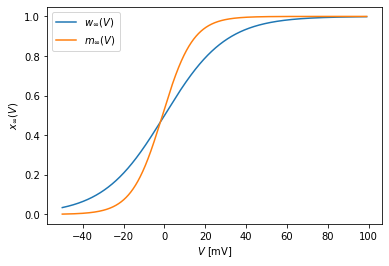

In [9]:
# Keep voltage between E_K and E_Ca
V_sweep = np.arange(E_K+20, E_Ca-1, .0001)

# Plot equilibrium values of gating variables
plt.plot(V_sweep, w_inf(V_sweep), label='$w_\infty(V)$')
plt.plot(V_sweep, m_inf(V_sweep), label='$m_\infty(V)$')
plt.xlabel('$V$ [mV]')
plt.ylabel('$x_\infty(V)$')
plt.legend()
plt.show()

In [10]:
# Generate nullclines for both state variables V and W
def plot_nc(V, I_ext):
  nc1 = I_ext - g_Ca*m_inf(V)*(V-E_Ca) - g_L*(V-E_L)
  nc1 /= g_K*(V-E_K)
  p = plt.plot(V, nc1, label='$\dot{V}$=0' + ' @ I = {:.2f}'.format(I_ext))
  plt.xlabel('V [mV]')
  plt.ylabel('W')

  nc2 = w_inf(V)
  plt.plot(V, nc2, label='$\dot{W}$=0' + ' @ I = {:.2f}'.format(I_ext))
  #plt.legend(loc='lower right')
  #plt.ylim(.2, .6)

  for intersection in V[np.abs(nc1 - nc2) <= 1e-6]:
    plt.axvline(x=intersection, c=p[0].get_color())

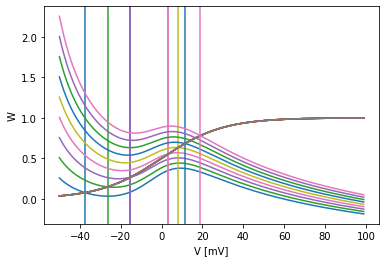

In [11]:
# Sweep current input and see how the nullclines shift
for I_ext in np.arange(10, 100, 10):
  plot_nc(V_sweep, I_ext)

# Vertical lines show where the nullclines intersect

In [12]:
# Can we get two intersection points?

In [13]:
# How do we determine whether the intersection is stable or unstable equlibrium?

# Further Reading
Stability analysis for reduced Hodgkin-Huxley models:

https://neurophysics.ucsd.edu/courses/physics_171/Reduced_Spike_Model.pdf

Bifurcation analysis of the AdEx neuron: 

http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model

Bard Ermentrout's INC chalk talk with SNICs:

https://youtu.be/XJYRTk5kRWE?t=2958 

